In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import shap

## Dataset

In [ ]:
# --- Carregamento ---#

data_df = pd.read_csv('Merged01.csv')

print(data_df.shape)
data_df.head()

(712311, 40)


,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
0,19.92,6,63.36,25893.962218,0.0,0.0,0.0,0.99,0.99,0.0,...,6421,60,481,64.21,42.100000,64.21,0.000039,100,1772.410000,DDOS-PSHACK_FLOOD
1,0.00,47,64.00,3703.841331,0.0,0.0,0.0,0.00,0.00,0.0,...,57320,98,578,573.20,48.000000,573.20,0.000271,100,2304.000000,MIRAI-GREIP_FLOOD
2,7.92,17,65.91,19673.095685,0.0,0.0,0.0,0.00,0.00,0.0,...,6010,60,70,60.10,1.000000,60.10,0.000057,100,1.000000,DOS-UDP_FLOOD
3,20.40,6,110.50,261.664826,0.1,0.0,0.3,0.20,0.40,0.0,...,2223,54,1500,222.30,451.596686,222.30,0.004766,10,203939.566667,DNS_SPOOFING
4,0.32,1,63.96,28944.199848,0.0,0.0,0.0,0.00,0.01,0.0,...,6006,60,66,60.06,0.600000,60.06,0.000035,100,0.360000,DDOS-ICMP_FLOOD


In [ ]:
# --- Carregamento ---#

# Primeira amostra
df1 = pd.read_csv('Merged01.csv')

# Segunda amostra
df2 = pd.read_csv('Merged02.csv')

# Concatena verticalmente (uma tabela embaixo da outra)
data_df = pd.concat([df1, df2], axis=0, ignore_index=True)

print(data_df.shape)
data_df.head()

(1460896, 40)


,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
0,19.92,6,63.36,25893.962218,0.0,0.0,0.0,0.99,0.99,0.0,...,6421,60,481,64.21,42.100000,64.21,0.000039,100,1772.410000,DDOS-PSHACK_FLOOD
1,0.00,47,64.00,3703.841331,0.0,0.0,0.0,0.00,0.00,0.0,...,57320,98,578,573.20,48.000000,573.20,0.000271,100,2304.000000,MIRAI-GREIP_FLOOD
2,7.92,17,65.91,19673.095685,0.0,0.0,0.0,0.00,0.00,0.0,...,6010,60,70,60.10,1.000000,60.10,0.000057,100,1.000000,DOS-UDP_FLOOD
3,20.40,6,110.50,261.664826,0.1,0.0,0.3,0.20,0.40,0.0,...,2223,54,1500,222.30,451.596686,222.30,0.004766,10,203939.566667,DNS_SPOOFING
4,0.32,1,63.96,28944.199848,0.0,0.0,0.0,0.00,0.01,0.0,...,6006,60,66,60.06,0.600000,60.06,0.000035,100,0.360000,DDOS-ICMP_FLOOD


In [ ]:
# --- Filtrar e remover colunas com inf --- #

# Criar uma cópia apenas com colunas numéricas
num_df = data_df.select_dtypes(include=[np.number])

# Criar máscara de infinitos (somente nas colunas numéricas)
inf_mask = num_df.map(np.isinf)

# Filtrar colunas que têm pelo menos um valor infinito
colunas_com_inf = inf_mask.any()

print("Colunas com valores infinitos:")
print(colunas_com_inf[colunas_com_inf].index.tolist())

# Remove linhas que tenham algum infinito
data_df = data_df[~inf_mask.any(axis=1)]

print("Número de linhas após remover infinitos em 'Rate':", data_df.shape[0])
print("Número de colunas:", data_df.shape[1])

Colunas com valores infinitos:
['Rate']
Número de linhas após remover infinitos em 'Rate': 712297
Número de colunas: 40


In [ ]:
attack_class_mapping = {
    # Benigno
    'BENIGN': 'Benign',

    # DDoS
    'DDOS-PSHACK_FLOOD': 'DDoS',
    'DDOS-ICMP_FLOOD': 'DDoS',
    'DDOS-TCP_FLOOD': 'DDoS',
    'DDOS-SYN_FLOOD': 'DDoS',
    'DDOS-UDP_FLOOD': 'DDoS',
    'DDOS-SYNONYMOUSIP_FLOOD': 'DDoS',
    'DDOS-RSTFINFLOOD': 'DDoS',
    'DDOS-SLOWLORIS': 'DDoS',
    'DDOS-ICMP_FRAGMENTATION': 'DDoS',
    'DDOS-ACK_FRAGMENTATION': 'DDoS',
    'DDOS-UDP_FRAGMENTATION': 'DDoS',
    'DDOS-HTTP_FLOOD': 'DDoS',

    # DoS
    'DOS-UDP_FLOOD': 'DoS',
    'DOS-TCP_FLOOD': 'DoS',
    'DOS-SYN_FLOOD': 'DoS',
    'DOS-HTTP_FLOOD': 'DoS',

    # Recon
    'RECON-HOSTDISCOVERY': 'Recon',
    'VULNERABILITYSCAN': 'Recon',
    'RECON-PORTSCAN': 'Recon',
    'RECON-OSSCAN': 'Recon',
    'RECON-PINGSWEEP': 'Recon'

}

attack_class_to_num = {
    'Benign': 0,
    'DDoS': 1,
    'DoS': 2,
    'Recon': 3
    #'Web-based': 4,
    #'Brute Force': 5,
    #'Spoofing': 6,
    #'Mirai': 7
}

(664743, 42)
Distribuição de classes (absoluta)
Attack_Class
1    515113
2    122494
0     16574
3     10562
Name: count, dtype: int64
Distribuição de classes (percentual)
Attack_Class
1    77.490549
2    18.427272
0     2.493294
3     1.588885
Name: proportion, dtype: float64


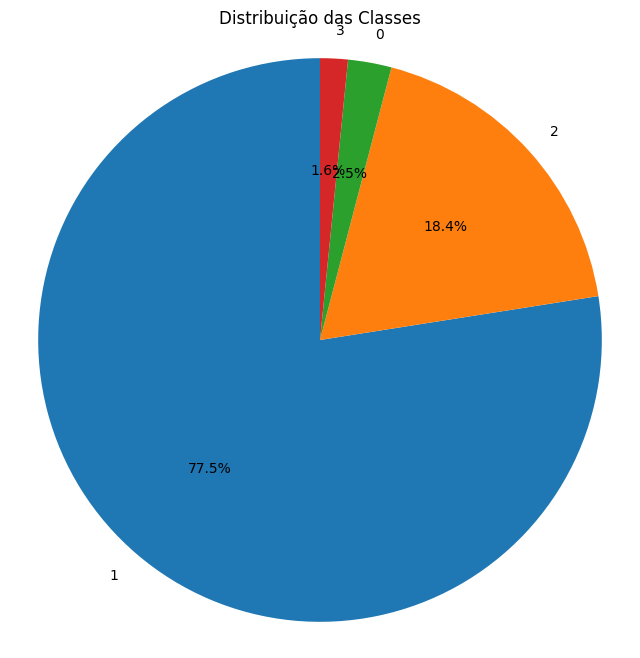

In [ ]:
# --- Mapeamento e filtragem de classes --- #

# Manter apenas classes presentes no mapping
data_df = data_df[data_df["Label"].isin(attack_class_mapping.keys())].copy()

# Aplicar o mapping (nome → número)
data_df['Attack_Type'] = data_df['Label'].map(attack_class_mapping)
data_df['Attack_Class'] = data_df['Attack_Type'].map(attack_class_to_num)

print(data_df.shape)
print("Distribuição de classes (absoluta)")
print(data_df['Attack_Class'].value_counts())
print("Distribuição de classes (percentual)")
print(data_df['Attack_Class'].value_counts(normalize=True) * 100)

# Gráfico
class_counts = data_df['Attack_Class'].value_counts()
labels =  class_counts.index
sizes = class_counts.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição das Classes')
plt.axis('equal')  # deixa o círculo redondo
plt.show()

## Treinamento

In [ ]:
# --- Mapeamento e filtragem de classes --- #

# Separar X e y
X = data_df.drop(columns=['Label', 'Attack_Type', 'Attack_Class'])
y = data_df['Attack_Class']                 # coluna alvo

# 1º Split: Treino + Temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2º Split: Validação e Teste
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Converter para DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Resultado
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (465320, 39)
Val: (99711, 39)
Test: (99712, 39)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.0 MB/s eta 0:00:00


In [ ]:
#--- Criação dos clientes FL ---#

# Variáveis globais para a simulação FL (definidas no código anterior)
num_clients = 4
num_boost_round = 50
rounds_per_client = 5

# Divisão do conjunto de treino em 4 clientes (silos de dados)
# Certifique-se de que X_train e y_train já estão definidos pelas células anteriores
X_train_clients = np.array_split(X_train, num_clients)
y_train_clients = np.array_split(y_train, num_clients)
dtrain_clients = []

for i in range(num_clients):
    dtrain_clients.append(xgb.DMatrix(X_train_clients[i], label=y_train_clients[i]))

print("Preparação dos dados dos clientes concluída para Optuna.")
# dval é o conjunto de validação global

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Preparação dos dados dos clientes concluída para Optuna.


In [ ]:
#--- Otimização de hiperparâmetros com Optuna ---#

# Importar Optuna
import optuna

def objective(trial):
    # 1. Sugestão de Hiperparâmetros
    params = {
        'objective': 'multi:softprob',
        'num_class': len(attack_class_to_num),
        'eval_metric': 'mlogloss',
        'verbosity': 0,

        # Parâmetros de Optimização
        'eta': trial.suggest_float('eta', 0.01, 0.3),                 # Learning Rate
        'max_depth': trial.suggest_int('max_depth', 6, 12),           # Profundidade máxima da árvore
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),     # Amostra de linhas para construir a árvore
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # Amostra de colunas para construir a árvore
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Regularização L2
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)    # Regularização L1
    }

    # 2. Inicialização do Modelo Global
    global_model = None

    # 3. Simulação do Treinamento Federado

    # Rodadas Globais totais
    num_global_rounds = int(num_boost_round / rounds_per_client)

    for global_round in range(num_global_rounds):

        for i in range(num_clients):
            dclient = dtrain_clients[i]

            # Treinamento Local: Continua o treinamento a partir do modelo global
            local_model = xgb.train(
                params,
                dclient,
                num_boost_round=rounds_per_client,
                xgb_model=global_model,
                evals=[],
                verbose_eval=False
            )

            # Atualização do Modelo Global (Simulação de Agregação)
            global_model = local_model

        # Callback para Optuna: Permite Early Stopping do trial
        # Avaliamos o modelo global no conjunto de validação
        eval_mlogloss_val = global_model.eval(dval, 'val_eval').split('\t')[1].split(':')[1]
        loss_val = float(eval_mlogloss_val)

        trial.report(loss_val, global_round)

        # Early Stopping para o Optuna (se a perda começar a subir significativamente)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 4. Retorna a métrica final de validação (mlogloss)
    return loss_val

# 5. Execução do Estudo Optuna
# Minimize a mlogloss (direção 'minimize')
study = optuna.create_study(direction='minimize')

# Executa 100 tentativas (você pode aumentar este número para maior precisão)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Resultados
print("\n--- Resultados do Optuna ---")
print(f"Melhor mlogloss de validação: {study.best_value:.4f}")
print("Melhores Parâmetros:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-25 20:20:03,725] A new study created in memory with name: no-name-00017a2c-4560-40da-a19b-7f547ca59a81


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-25 20:21:50,186] Trial 0 finished with value: 0.3099454352594397 and parameters: {'eta': 0.13297480093574074, 'max_depth': 10, 'subsample': 0.6013958065099426, 'colsample_bytree': 0.7738409036329719, 'lambda': 9.101540827162678e-06, 'alpha': 3.83477891257335e-05}. Best is trial 0 with value: 0.3099454352594397.
[I 2025-11-25 20:23:21,883] Trial 1 finished with value: 0.3185465277384854 and parameters: {'eta': 0.2329294577803031, 'max_depth': 9, 'subsample': 0.8810298052506436, 'colsample_bytree': 0.8945246578212414, 'lambda': 1.455348076950423e-08, 'alpha': 3.401684818237757e-08}. Best is trial 0 with value: 0.3099454352594397.
[I 2025-11-25 20:25:05,192] Trial 2 finished with value: 0.3289178414378843 and parameters: {'eta': 0.26569889979648437, 'max_depth': 10, 'subsample': 0.6895075084101084, 'colsample_bytree': 0.6401667026247597, 'lambda': 2.5173442000967105e-08, 'alpha': 3.7822781200007356e-08}. Best is trial 0 with value: 0.3099454352594397.
[I 2025-11-25 20:26:18,593

In [ ]:
#--- Treinamento com os melhores parâmetros ---#

# Recuperar os melhores parâmetros
best_params = study.best_params

# Adicionar os parâmetros fixos
best_params.update({
    'objective': 'multi:softprob',
    'num_class': len(attack_class_to_num),
    'eval_metric': 'mlogloss',
    'verbosity': 1
})

# Repetição do Treinamento Federado Final (para capturar o logloss para o plot)

final_global_model = None
evals_result_final = {'train': {'mlogloss': []}, 'val': {'mlogloss': []}}
num_global_rounds = int(num_boost_round / rounds_per_client)

print("\n--- Treinando Modelo Global Final com os Melhores Parâmetros ---")

for global_round in range(num_global_rounds):

    for i in range(num_clients):
        dclient = dtrain_clients[i]

        local_model = xgb.train(
            best_params,
            dclient,
            num_boost_round=rounds_per_client,
            xgb_model=final_global_model,
            evals=[(dclient, 'local_train')],
            verbose_eval=False
        )

        final_global_model = local_model

    # Avaliação e armazenamento para o plot
    eval_mlogloss_val = final_global_model.eval(dval, 'val_eval').split('\t')[1].split(':')[1]
    eval_mlogloss_train = final_global_model.eval(dtrain_clients[0], 'train_eval').split('\t')[1].split(':')[1]

    evals_result_final['train']['mlogloss'].extend([float(eval_mlogloss_train)] * rounds_per_client)
    evals_result_final['val']['mlogloss'].extend([float(eval_mlogloss_val)] * rounds_per_client)

print("\n✅ Treinamento Federado Final Concluído.")


--- Treinando Modelo Global Final com os Melhores Parâmetros ---

✅ Treinamento Federado Final Concluído.


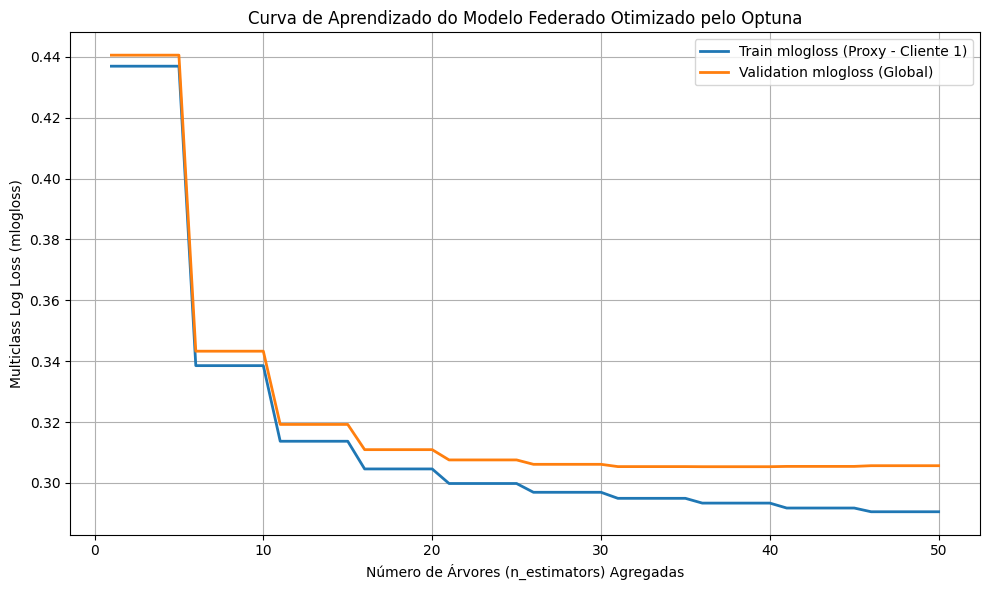

In [ ]:
# --- Plotar mlogloss vs n_estimators (Modelo Otimizado) ---#

# Usa os resultados armazenados do treinamento final com Optuna
total_rounds = len(evals_result_final['val']['mlogloss'])
rounds = list(range(1, total_rounds + 1))

plt.figure(figsize=(10, 6))

# Nota: 'train' é um proxy (Cliente 1), 'val' é a avaliação do Servidor Global
plt.plot(rounds, evals_result_final['train']['mlogloss'], label='Train mlogloss (Proxy - Cliente 1)', linewidth=2)
plt.plot(rounds, evals_result_final['val']['mlogloss'], label='Validation mlogloss (Global)', linewidth=2)
plt.xlabel('Número de Árvores (n_estimators) Agregadas')
plt.ylabel('Multiclass Log Loss (mlogloss)')
plt.title('Curva de Aprendizado do Modelo Federado Otimizado pelo Optuna')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Resultados


--- Avaliação Final do Modelo Global Otimizado ---
📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86      2486
         1.0       0.86      0.97      0.91     77267
         2.0       0.72      0.35      0.47     18374
         3.0       0.79      0.74      0.77      1585

    accuracy                           0.85     99712
   macro avg       0.80      0.73      0.75     99712
weighted avg       0.83      0.85      0.83     99712

✅ Accuracy: 0.8482529685494223


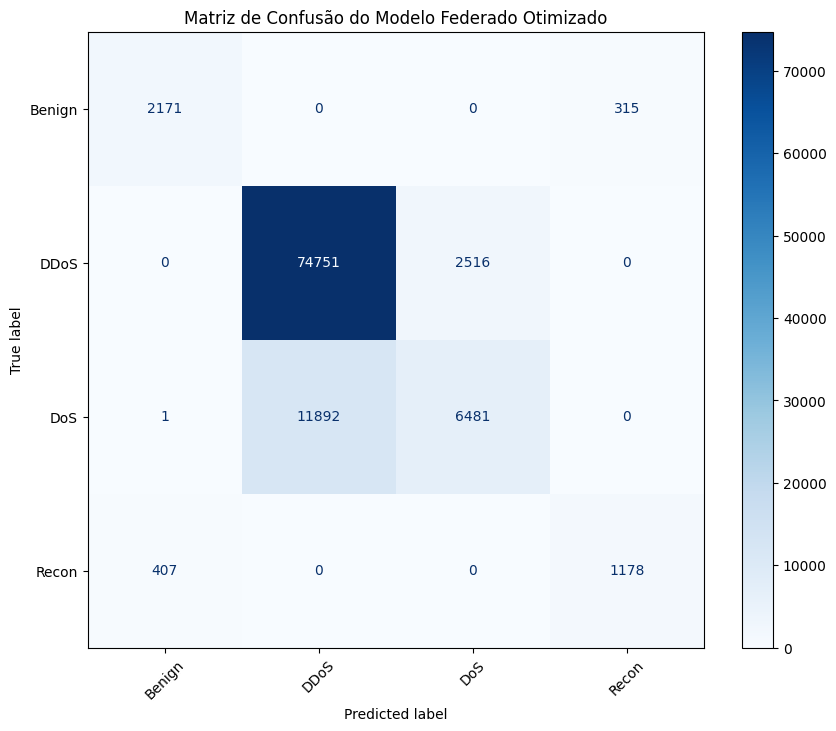

In [ ]:
# --- Relatório de métricas e matriz de confusão --- #

# Previsões em forma de probabilidade, usando o modelo final Otimizado
y_pred_prob = final_global_model.predict(dtest)

# Converter para rótulos (classe com maior probabilidade)
y_pred = np.argmax(y_pred_prob, axis=1)

# Valores reais do conjunto de teste
y_true = dtest.get_label()

print("\n--- Avaliação Final do Modelo Global Otimizado ---")
print("📊 Classification Report:")

# Gera o relatório de classificação
print(classification_report(y_true, y_pred))

print("✅ Accuracy:", accuracy_score(y_true, y_pred))

# --- Matriz de Confusão ---

# Nomes das classes para exibição na Matriz de Confusão
class_names = list(attack_class_to_num.keys())

# Gerar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plotar a imagem
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title('Matriz de Confusão do Modelo Federado Otimizado')
plt.show()

            feature  importance
36           Number  168.901062
4   fin_flag_number   31.765659
7   psh_flag_number   14.153264
23              UDP   13.476315
0     Header_Length   12.868620
34         Tot size   12.596191
29          Tot sum   12.298647
13        fin_count   10.341236
22              TCP   10.105556
26             ICMP    8.339017
5   syn_flag_number    8.218072
35              IAT    5.211468
32              AVG    5.023398
14        rst_count    4.968405
11        ack_count    4.624394
16            HTTPS    4.314229
12        syn_count    4.313516
8   ack_flag_number    4.241556
3              Rate    4.105019
6   rst_flag_number    4.066515
25              ARP    3.310550
30              Min    3.167847
1     Protocol Type    2.892458
15             HTTP    2.481964
18           Telnet    2.404356
9   ece_flag_number    2.377212
31              Max    2.339483
2      Time_To_Live    2.313992
10  cwr_flag_number    2.128431
28              IPv    2.046570
37      

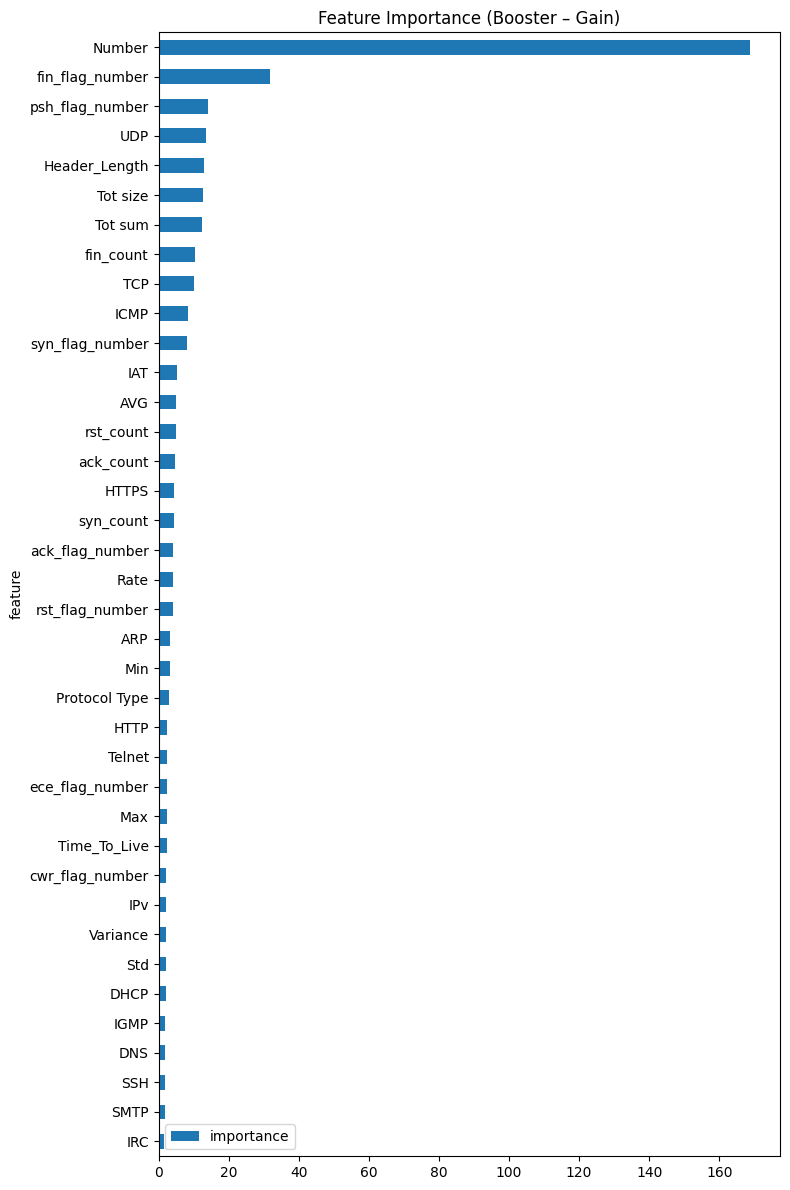

In [ ]:
# --- Importância das features no modelo XGBoost --- #

# Calcula importância por ganho
booster = final_global_model
score = booster.get_score(importance_type='gain')

booster_features = list(score.keys())
original_features = list(X_train.columns)

# Mapeamento seguro
feature_map = {}
for f in booster_features:
    try:
        idx = int(f[1:])
        if idx < len(original_features):
            feature_map[f] = original_features[idx]
        else:
            feature_map[f] = f"unknown_{idx}"
    except:
        feature_map[f] = f

# Construir DataFrame final
feature_importance = (
    pd.DataFrame(score.items(), columns=['feature', 'importance'])
      .assign(feature=lambda df: df['feature'].map(feature_map))
      .sort_values('importance', ascending=False)
)

print(feature_importance)

# Plot
feature_importance.sort_values("importance").plot(
    x="feature", y="importance", kind="barh", figsize=(8,12)
)
plt.title("Feature Importance (Booster – Gain)")
plt.tight_layout()
plt.show()


## Aplicando o XAI

PermutationExplainer explainer: 1001it [08:32,  1.93it/s]
/tmp/ipython-input-3271434306.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, max_display=10)


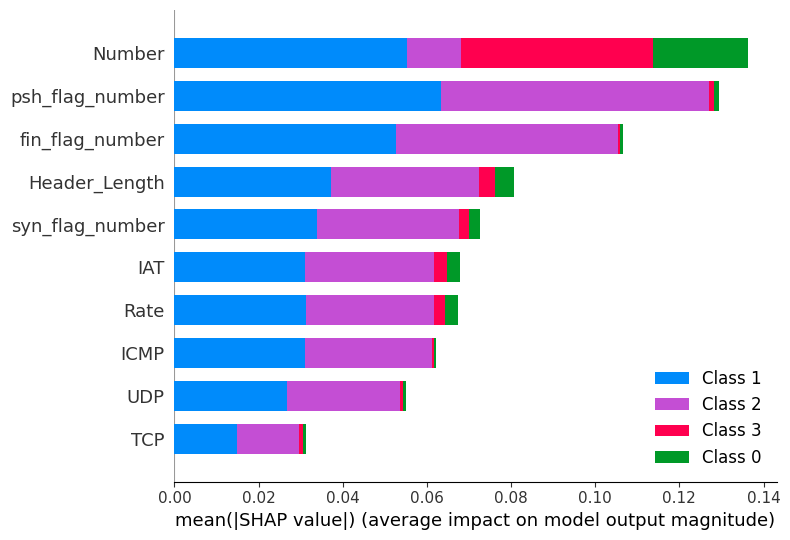

In [ ]:
# --- Visão geral --- #

# Pega 1000 amostras aleatórias
X_sample, _ , y_sample, _ = train_test_split(
    X_test, y_test,
    test_size=len(X_test) - 1000,
    stratify=y_test,
    random_state=42
)

# Wrapper: transforma o modelo em chamável
def model_predict_proba(X):
    d = xgb.DMatrix(X)
    return final_global_model.predict(d)

# Cria explainer SHAP
explainer = shap.Explainer(model_predict_proba, X_train)

# Calcula SHAP values
shap_values = explainer(X_sample)  # shap_values[X, features, classes]

# Visualização geral
shap.summary_plot(shap_values, X_sample, max_display=10)

Classe Benign


/tmp/ipython-input-2675543884.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, i], X_sample, max_display=10)


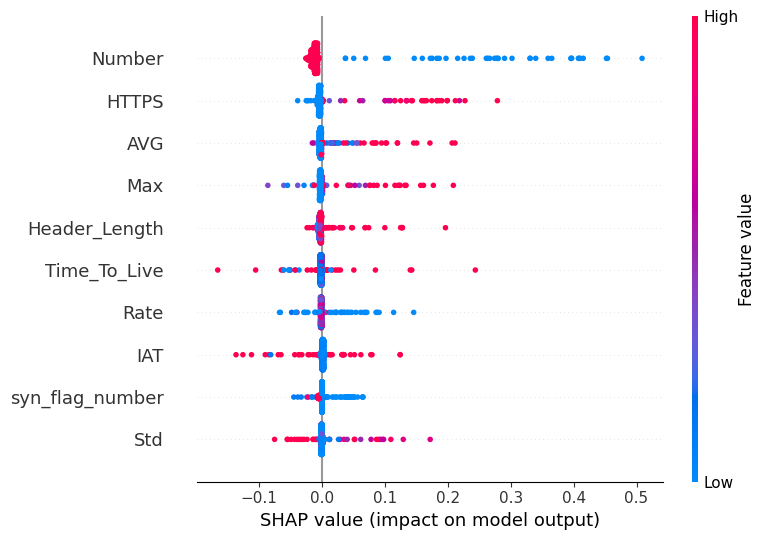

Classe DDoS


/tmp/ipython-input-2675543884.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, i], X_sample, max_display=10)


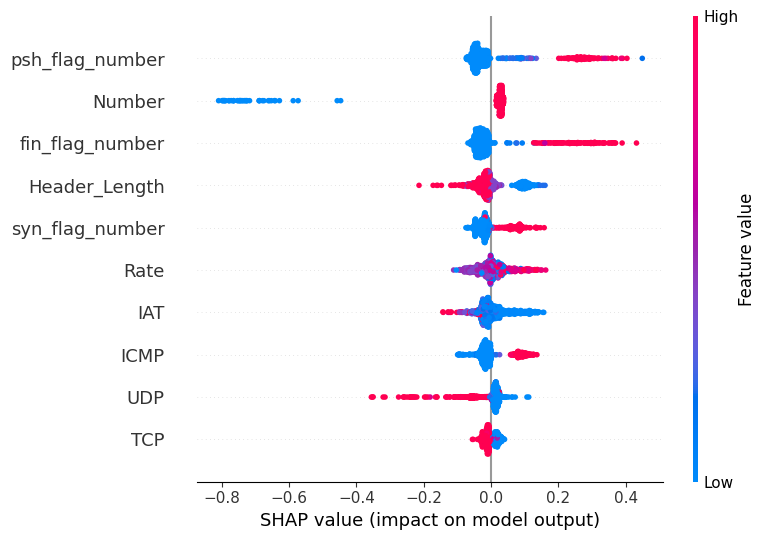

Classe DoS


/tmp/ipython-input-2675543884.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, i], X_sample, max_display=10)


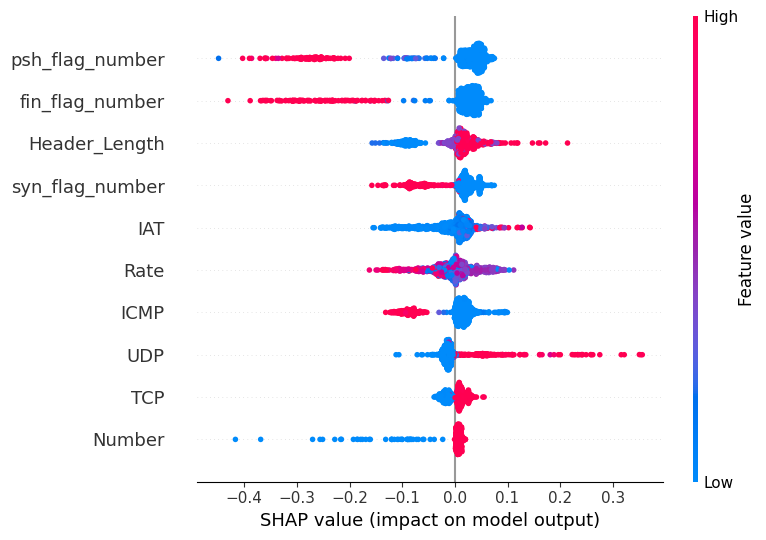

Classe Recon


/tmp/ipython-input-2675543884.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, i], X_sample, max_display=10)


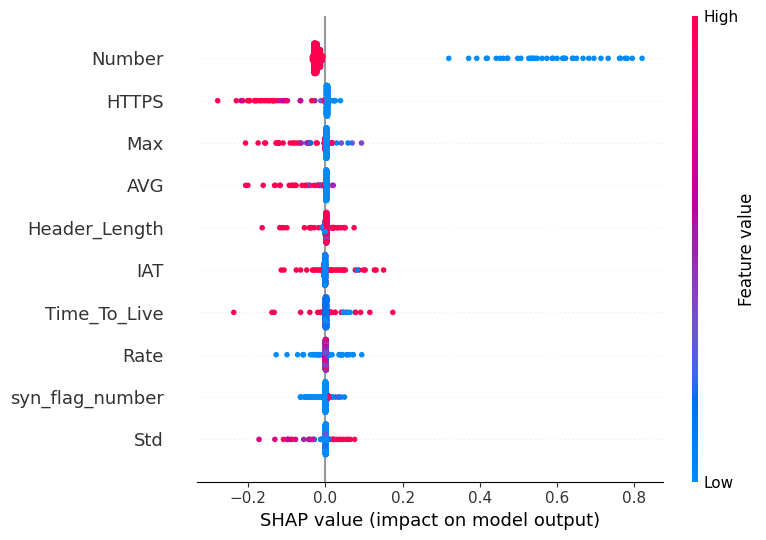

In [ ]:
# --- Visão por classe --- #

# Mapa num -> class
num_to_attack_class = {v: k for k, v in attack_class_to_num.items()}

# shap_values[X, features, classes]
for i in range(shap_values.shape[2]):  # iteração por classe
    print(f"Classe {num_to_attack_class[i]}")
    shap.summary_plot(shap_values[:, :, i], X_sample, max_display=10)

In [ ]:
# --- Visão por amostra --- #

# Mapeando índices (uma amostra por classe)
indices_por_classe = {}
for c in np.unique(y_sample):
    idx = X_sample[y_sample == c].index[0]   # pega o primeiro índice da classe
    indices_por_classe[c] = idx

# Gráfico
shap.initjs()

for classe, idx in indices_por_classe.items():

    print(f"Classe {classe}  ({num_to_attack_class[classe]})")
    print(f"Amostra índice: {idx}")

    base = shap_values.base_values[X_sample.index.get_loc(idx), classe]
    shap_vec = shap_values.values[X_sample.index.get_loc(idx), :, classe]
    feat_vec = shap_values.data[X_sample.index.get_loc(idx), :]

    display(
        shap.force_plot(
            base,
            shap_vec,
            feat_vec,
            feature_names=X_sample.columns
        )
    )

Classe 0  (Benign)
Amostra índice: 185421


Classe 1  (DDoS)
Amostra índice: 605619


Classe 2  (DoS)
Amostra índice: 572096


Classe 3  (Recon)
Amostra índice: 155503
